In [1]:
PATH_ = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"

In [2]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score
import os 
from matplotlib import pyplot as plt
import pickle
import seaborn as sb
import pandas as pd
import numpy as np
from scipy import stats
import sys
sys.path.append('C:\\Users\\ICN_admin\\Documents\\icn\\icn_stats\\')
import icn_permutation_test

In [3]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

In [4]:
def evalerror(preds, dtrain):
        """
        Custom defined r^2 evaluation function
        """
        labels = dtrain.get_label()
        # return a pair metric_name, result. The metric name must not contain a
        # colon (:) or a space since preds are margin(before logistic
        # transformation, cutoff at 0)

        r2 = metrics.r2_score(labels, preds)

        if r2 < 0:
            r2 = 0

        return 'r2', r2

In [160]:
model = xgb.XGBRegressor()
df = pd.DataFrame()
for f in range(len(os.listdir(PATH_))):
    sub_ = os.listdir(PATH_)[f][4:7]
    if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        continue
    print(sub_)
    with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
        run_ = pickle.load(handle)
        print(run_["ch_names"])
        if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
            continue
        print("PROCESS")
        for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
            if "ECOG" in ch_:
                loc = "ECOG"
            else:
                loc = "STN"
            for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                if run_["label_con_true"][label_idx] is True:
                    lat = "CON"
                else:
                    lat = "IPS"
                X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], label, time_stamps=5)
                #res_ = np.mean(cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=59))
                res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X, label=y), 
                              feval=evalerror, nfold=3, shuffle=False).iloc[-1]["test-r2-mean"]
                print(res_)
                if "LEFT" in ch_:
                    hem = "LEFT"
                else:
                    hem = "RIGHT"
                df = df.append({
                    "r2": res_,
                    "ch_": ch_,
                    "sub": sub_,
                    "loc": loc,
                    "lat": lat,
                    "hem" : hem
                }, ignore_index=True)
            

000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
0.0
0.42269033333333333
0.17122433333333334
0.6432570000000001
0.03319833333333334
0.5974119999999999
0.45378300000000005
0.8036583333333334
0.5354450000000001
0.6964053333333333
0.39733233333333334


KeyboardInterrupt: 

In [163]:
X.shape

(2805, 40)

In [164]:
y.shape

(2805,)

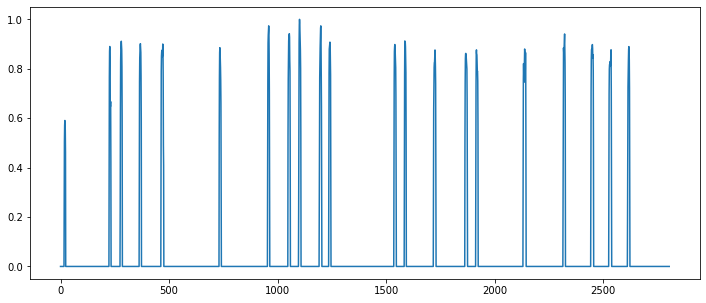

In [165]:
plt.figure(figsize=(12,5))
plt.plot(y)

### 1. step define individual movements as consecutive groups!

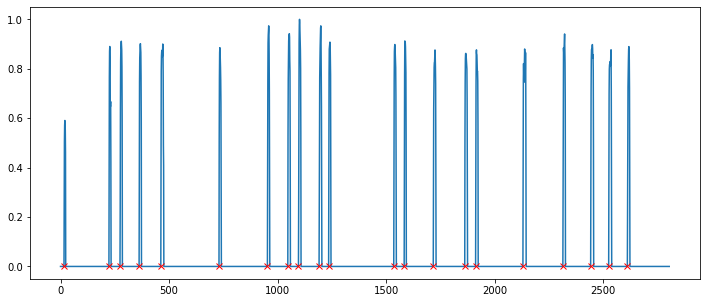

In [166]:
# only take 0-1 flanks (positive binary derivative)
plt.figure(figsize=(12,5))
plt.plot(y)
crossings = np.where(np.diff(np.array(y>0.1).astype(int))>0)[0]
plt.plot(crossings, y[crossings], "x", color="red")

In [167]:
# now for each crossing assign consecutive groups
group_id = 0
groups = np.zeros([y.shape[0]])
for i in range(0,y.shape[0]):
    if i in crossings:
        group_id +=1
    groups[i] = group_id

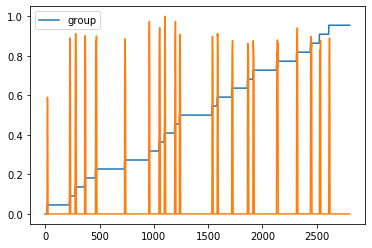

In [168]:
plt.plot(groups/np.unique(groups).shape[0], label="group")
plt.plot(y)
plt.legend()

In [190]:
# use group k vold CV: https://scikit-learn.org/stable/modules/cross_validation.html
from sklearn.model_selection import LeavePGroupsOut, GroupShuffleSplit

In [187]:
np.unique(groups).shape

(22,)

In [182]:
n_groups_out = int(np.unique(groups).shape[0]/10) # resembling 10 fold CV

In [185]:
lpgo = LeavePGroupsOut(n_groups=n_groups_out)

In [191]:
gss = GroupShuffleSplit(n_splits=10, train_size=.9, random_state=42)

In [192]:
gss.get_n_splits()

10

In [186]:
lpgo.get_n_splits(groups=groups)

231

In [173]:
X.shape

(2805, 40)

In [174]:
y.shape

(2805,)

In [175]:
from sklearn import utils

In [102]:
lpgo = LeavePGroupsOut(n_groups=n_groups_out)
for train, test in lpgo.split(X, y, groups=groups):
    X_train = X[train,:]; X_test = X[test,:]
    y_train = y[train]; y_test = y[test]
    
    #optionally sample from train set 
    y_high = y_train[np.where(np.array(y_train>0.1)>0)[0]]
    X_tr_high = X_train[np.where(np.array(y_train>0.1)>0)[0]]
    
    y_low = y_train[np.where(np.array(y_train<0.01)>0)[0]]
    X_tr_low = X_train[np.where(np.array(y_train<0.01)>0)[0]]
    
    # shuffle data, the clip to ensure same shape as movement
    X_tr_low, y_low = utils.shuffle(X_tr_low, y_low)
    X_tr_low = X_tr_low[:y_high.shape[0]]
    y_low = y_low[:y_high.shape[0]]
    
    # concatenate low and high segments
    X_train = np.concatenate((X_tr_low, X_tr_high))
    y_train = np.concatenate((y_low, y_high))
    X_train, y_train = utils.shuffle(X_train, y_train)
    
    # train model 
    

In [142]:
np.unique(groups)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22.])

In [143]:
n_groups_out

7

In [147]:
groups.shape

(2805,)

In [150]:
groups[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [179]:
lpgo.get_n_splits(groups=groups)

26334

In [161]:
lpgo.get_n_splits(groups=2)

TypeError: Singleton array array(2) cannot be considered a valid collection.

In [162]:
lpgo = LeavePGroupsOut(n_groups=5)
for train, test in lpgo.split(X, y, groups=groups):
    print("train")
    print(train)
    print("test")
    print(test)
    print("1")

ValueError: Found input variables with inconsistent numbers of samples: [2805, 2805, 6]

In [155]:
X = np.arange(6)
y = [1, 1, 1, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3]
lpgo = LeavePGroupsOut(n_groups=1)
for train, test in lpgo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[2 3 4 5] [0 1]
[0 1 4 5] [2 3]
[0 1 2 3] [4 5]


In [156]:
LeavePGroupsOut?

In [103]:
X_train.shape

(416, 40)

In [104]:
y_train.shape

(416,)

In [105]:
X_test.shape

(86, 40)

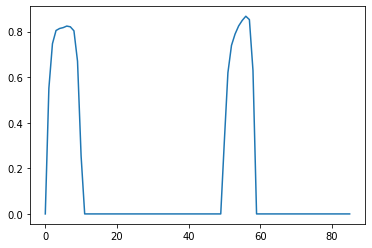

In [106]:
plt.plot(y_test)

### implement into bigger res analysis

In [195]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn import utils, metrics

def balanced_leave_k_groups_out_CV(model, X, y, plt_=True, same_size=True):
    
    crossings = np.where(np.diff(np.array(y>0.1).astype(int))>0)[0]
    
    if plt_ is True:
        plt.figure(figsize=(12,5))
        plt.plot(y)
        crossings = np.where(np.diff(np.array(y>0.1).astype(int))>0)[0]
        plt.plot(crossings, y[crossings], "x", color="red")
        plt.title("crossings")

    group_id = 0
    groups = np.zeros([y.shape[0]])
    for i in range(0,y.shape[0]):
        if i in crossings:
            group_id +=1
        groups[i] = group_id
    
    if plt_ is True:
        plt.figure(figsize=(12,5))
        plt.plot(groups/np.unique(groups).shape[0], label="group")
        plt.plot(y)
        plt.legend()
        plt.title("group identification")
        plt.show()
    
    gss = GroupShuffleSplit(n_splits=10, train_size=.9, random_state=42)
    r2_res = []
    y_test_pr_ = []
    y_test_ = []
    
    for train, test in gss.split(X, y, groups):
        X_train = X[train,:]; X_test = X[test,:]
        y_train = y[train]; y_test = y[test]

        #optionally sample from train set 
        y_high = y_train[np.where(np.array(y_train>0.1)>0)[0]]
        X_tr_high = X_train[np.where(np.array(y_train>0.1)>0)[0]]

        y_low = y_train[np.where(np.array(y_train<0.01)>0)[0]]
        X_tr_low = X_train[np.where(np.array(y_train<0.01)>0)[0]]

        # shuffle data, the clip to ensure same shape as movement
        X_tr_low, y_low = utils.shuffle(X_tr_low, y_low)
        
        if same_size is True:
            X_tr_low = X_tr_low[:y_high.shape[0]]
            y_low = y_low[:y_high.shape[0]]

        # concatenate low and high segments
        X_train = np.concatenate((X_tr_low, X_tr_high))
        y_train = np.concatenate((y_low, y_high))
        X_train, y_train = utils.shuffle(X_train, y_train)
        
        model.fit(X_train, y_train)
        y_test_pr = model.predict(X_test)
        r2_here = metrics.r2_score(y_test, y_test_pr)
        
        if plt_ is True:
            plt.figure(figsize=(12,5))
            plt.plot(y_test, label="label")
            plt.plot(y_test_pr, label="prediction")
            plt.legend()
            plt.title("r2="+str(np.round(r2_here,2)))
            plt.show()

        if r2_here <0:
            r2_here = 0
        r2_res.append(r2_here)
        y_test_pr_.append(y_test_pr); y_test_.append(y_test)
    print("overall mean: "+str(np.round(np.mean(r2_res),2)))
    return r2_res, y_test_pr_, y_test_

In [197]:
model = xgb.XGBRegressor()
df_same_size = pd.DataFrame()
for f in range(len(os.listdir(PATH_))):
    sub_ = os.listdir(PATH_)[f][4:7]
    if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        continue
    print(sub_)
    with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
        run_ = pickle.load(handle)
        print(run_["ch_names"])
        if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
            continue
        print("PROCESS")
        for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
            print(ch_)
            if "ECOG" in ch_:
                loc = "ECOG"
            else:
                loc = "STN"
            for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                if run_["label_con_true"][label_idx] is True:
                    lat = "CON"
                else:
                    lat = "IPS"
                print(lat)
                X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], label, time_stamps=5)
                #res_ = np.mean(cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=59))
                #res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X, label=y), 
                #              feval=evalerror, nfold=3, shuffle=False).iloc[-1]["test-r2-mean"]
                
                res_, _, _ = balanced_leave_k_groups_out_CV(xgb.XGBRegressor(), X, y, plt_=False, same_size=True)
                
                print(res_)
                if "LEFT" in ch_:
                    hem = "LEFT"
                else:
                    hem = "RIGHT"
                df_same_size = df_same_size.append({
                    "r2": np.mean(res_),
                    "ch_": ch_,
                    "sub": sub_,
                    "loc": loc,
                    "lat": lat,
                    "hem" : hem
                }, ignore_index=True)
            

000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
STN_RIGHT_0
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CON
overall mean: 0.05
[0.07249396244485495, 0, 0.03133888647059846, 0, 0, 0.17090759242767983, 0, 0.18246517312794053, 0, 0]
STN_RIGHT_1
IPS
overall mean: 0.01
[0, 0, 0, 0, 0, 0, 0, 0, 0.14580675057617654, 0]
CON
overall mean: 0.27
[0.5133891417263383, 0, 0.3369143037565907, 0, 0.27168950605145337, 0.7256382042740692, 0, 0.2892221724139078, 0.2944540906394121, 0.303647698039

overall mean: 0.01
[0.06118132715332536, 0, 0.03128714776120933, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_12
CON
overall mean: 0.0
[0.01881985033372291, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_13
CON
overall mean: 0.01
[0.0573069063089634, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_14
CON
overall mean: 0.03
[0.19489091487060706, 0.07116241168527637, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_15
CON
overall mean: 0.06
[0.33511766204196103, 0.17942933296602792, 0, 0, 0, 0, 0.11564742778372394, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_16
CON
overall mean: 0.05
[0.43947793833498405, 0.024916518468872884, 0, 0, 0, 0, 0.03816508940143748, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_17
CON
overall mean: 0.01
[0.12321675319516168, 0, 0, 0, 0, 0, 0, 0, 0, 

['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
STN_LEFT_0
CON
overall mean: 0.01
[0, 0, 0, 0, 0, 0, 0, 0.0602337634163177, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
STN_LEFT_1
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0.0061583687111480545, 0, 0]
IPS
overall mean: 0.01
[0, 0, 0, 0, 0, 0, 0, 0, 0.07046376544949451, 0]
STN_LEFT_2
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0.01774912364003267, 0, 0]
IPS
overall mean: 0.01
[0, 0, 0, 0, 0, 0, 0, 0, 0.06538513664697532, 0]
ECOG_LEFT_0
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.06
[0, 0, 0, 0, 0, 0.15150441001742543, 0.19240417736743498, 0, 0.2265874844421214, 0]
ECOG_LEFT_1
CON
overall mean: 0.01
[0, 0, 0, 0, 0, 0, 0, 0.09361539027120946, 0, 0]
IPS
overall mean: 0.03
[0, 0, 0, 0, 0, 0, 0.1332186580325968, 0, 0.1869198525653072, 0]
ECOG_LEFT_2
CON

overall mean: 0.04
[0, 0, 0, 0, 0, 0, 0, 0, 0.2523678633263041, 0.16332153541365912]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
STN_LEFT_1
CON
overall mean: 0.03
[0, 0, 0, 0, 0, 0, 0, 0, 0.13147001527930235, 0.12070815225466691]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
STN_LEFT_2
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_0
CON
overall mean: 0.01
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0952110370172754]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_1
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_2
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_3
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_4
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0

overall mean: 0.01
[0, 0, 0, 0, 0, 0.09230455627558698, 0, 0, 0, 0]
ECOG_LEFT_14
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0.018364742066882433, 0, 0, 0, 0]
ECOG_LEFT_15
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.03939433422357175]
IPS
overall mean: 0.01
[0, 0, 0, 0, 0, 0.1273851825889748, 0, 0, 0, 0]
ECOG_LEFT_16
CON
overall mean: 0.0
[0.02496627956275499, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.04
[0, 0, 0, 0, 0, 0.23069147722832106, 0, 0, 0, 0.13667188404576736]
ECOG_LEFT_17
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0.007059638527889156, 0, 0, 0, 0]
IPS
overall mean: 0.05
[0, 0, 0, 0, 0, 0.26794000490213854, 0, 0, 0, 0.2473775958683342]
ECOG_LEFT_18
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.03
[0, 0, 0, 0, 0, 0.14342746334878287, 0, 0, 0, 0.12771330765664923]
ECOG_LEFT_19
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_20
CON

overall mean: 0.07
[0, 0.2676553207996475, 0, 0.20941808782179305, 0.26670681286113007, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_31
CON
overall mean: 0.07
[0, 0.1489269942794733, 0, 0.04737751865252482, 0.39556571545700403, 0, 0, 0, 0.13614208576955444, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_32
CON
overall mean: 0.01
[0, 0, 0, 0, 0.07035366340462623, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_33
CON
overall mean: 0.01
[0, 0, 0, 0, 0.14298896799896754, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_34
CON
overall mean: 0.02
[0, 0, 0, 0, 0.19038625559682598, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_35
CON
overall mean: 0.0
[0, 0, 0, 0, 0.04241194618831956, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
006
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', '

overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
STN_LEFT_1
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
STN_LEFT_2
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_0
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0.008411971148298059, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_1
CON
overall mean: 0.01
[0, 0, 0, 0, 0, 0.05717049054841439, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_2
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_3
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_4
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_5
CON
overall mean: 0.0
[0

overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_1
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_2
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_3
CON
overall mean: 0.01
[0, 0, 0, 0, 0, 0, 0, 0.07125032182253666, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_4
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ECOG_LEFT_5
CON
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
IPS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
013
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT

In [198]:
model = xgb.XGBRegressor()
df_non_same_size = pd.DataFrame()
for f in range(len(os.listdir(PATH_))):
    sub_ = os.listdir(PATH_)[f][4:7]
    if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        continue
    print(sub_)
    with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
        run_ = pickle.load(handle)
        print(run_["ch_names"])
        if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
            continue
        print("PROCESS")
        for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
            if "ECOG" in ch_:
                loc = "ECOG"
            else:
                loc = "STN"
            for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                if run_["label_con_true"][label_idx] is True:
                    lat = "CON"
                else:
                    lat = "IPS"
                X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], label, time_stamps=5)
                #res_ = np.mean(cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=59))
                #res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X, label=y), 
                #              feval=evalerror, nfold=3, shuffle=False).iloc[-1]["test-r2-mean"]
                
                res_, _, _ = balanced_leave_k_groups_out_CV(xgb.XGBRegressor(), X, y, plt_=False, same_size=False)
                
                print(res_)
                if "LEFT" in ch_:
                    hem = "LEFT"
                else:
                    hem = "RIGHT"
                df_non_same_size = df_non_same_size.append({
                    "r2": np.mean(res_),
                    "ch_": ch_,
                    "sub": sub_,
                    "loc": loc,
                    "lat": lat,
                    "hem" : hem
                }, ignore_index=True)
            

000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
overall mean: 0.02
[0, 0, 0, 0.0884318467899271, 0, 0, 0, 0.14171896699498066, 0, 0]
overall mean: 0.5
[0.7259124973073229, 0.5903876458266111, 0.7053508855807933, 0.20356909805121415, 0.3406060042890683, 0.4260786610806868, 0.449699999760102, 0.6669693400100172, 0.3949114151176063, 0.5417552344364568]
overall mean: 0.14
[0.11734068324120928, 0.2145234406539973, 0, 0.12040956237120781, 0, 0.08061702436052809, 0, 0.0992386751654617, 0.54584

overall mean: 0.17
[0.1110358053067777, 0.1490207467427418, 0, 0.20111178932618545, 0.23628962758741878, 0.3101359995235735, 0.33447788123237343, 0.2335627175663736, 0, 0.08181758840730569]
overall mean: 0.02
[0, 0, 0, 0, 0.03704356745393178, 0, 0.1612142530777162, 0, 0, 0]
overall mean: 0.38
[0.42193285737294417, 0.20642591958878187, 0.5159411941878, 0.44494682510835903, 0.394201943015728, 0.4314309309696335, 0.6634098286946936, 0.32106124731252794, 0.32006274089323883, 0.06593145104519127]
overall mean: 0.11
[0, 0.05785371063239808, 0, 0.20685825985544715, 0.18028305153850832, 0.4067251490021556, 0.11851591713946585, 0.0030932726444130587, 0.13485804048548844, 0]
overall mean: 0.44
[0.6872919447639421, 0.33857300944283086, 0.5428439436899852, 0.3637994785246873, 0.4157836784178739, 0.519944290996963, 0.6170305215592877, 0.4328022122517652, 0.3612153139489166, 0.15489105719504004]
overall mean: 0.13
[0, 0.19625846964148563, 0, 0, 0.09519288051983255, 0.2548147875446528, 0.400145841996

overall mean: 0.01
[0, 0, 0, 0, 0.10495207224762237, 0, 0.02089506534575425, 0, 0, 0]
001
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.05
[0.14136256939272873, 0.03376010320520406, 0, 0.08309156110422111, 0, 0, 0, 0, 0.24001652610636137, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.01
[0, 0.12550639869303604, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0.030799382266667674, 0]
overall m

overall mean: 0.08
[0.13214638239408916, 0.11397010514672024, 0.13249051981146753, 0.10744055863017832, 0, 0, 0.2824413196679194, 0, 0.024793822501832707, 0.053637162683711326]
overall mean: 0.05
[0, 0.13420263614520556, 0.02377325923232332, 0, 0, 0, 0.14336726403780775, 0.12663767347991917, 0.10371723152574397, 0]
overall mean: 0.06
[0.05938323808916646, 0.12123651191012463, 0.1259747501148839, 0.07720902539509222, 0, 0, 0.008664047441348632, 0, 0.03324892419445613, 0.14463236058366524]
overall mean: 0.03
[0.010076042992989587, 0.08167723284611694, 0, 0, 0, 0, 0, 0.09556259899981301, 0.07869955390447114, 0]
overall mean: 0.01
[0, 0, 0.01843115684977603, 0.0338950950156397, 0, 0, 0, 0, 0.07308916825524236, 0]
overall mean: 0.01
[0, 0, 0, 0, 0, 0, 0, 0.07495018347639504, 0, 0]
overall mean: 0.01
[0, 0.05011518636247958, 0.013111172111410219, 0.0012761289593998804, 0, 0, 0, 0, 0, 0]
001
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG

overall mean: 0.02
[0, 0, 0.16941335704836868, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0.025830273715330088, 0, 0, 0, 0, 0, 0, 0, 0]
005
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
005
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
overall mean: 0.13
[0, 0.23841281411764648, 0.1380858001756391, 0, 0, 0, 0, 0.44478065907391484, 0.24943649905405207, 0.19524005017691382]
overall mean: 0.01
[0, 0, 0, 0, 0, 0.03862441398493266, 0, 0.07279691779422903, 0, 0]
overall mean: 0.14
[0.25895733255889275, 0, 0.4423240123812774, 0, 0, 0, 0, 0.27210772421167817, 0.2410138998442829, 0.19644924651293816]
overall mean: 0.01
[0, 0, 0, 0, 0, 0, 0, 0.11295409682284985, 0, 0]
overall mean: 0.08
[0, 0, 0.1736896939389031, 0, 0.06387062324704706, 0, 0, 0.30074

overall mean: 0.01
[0, 0.06849960999933069, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.11
[0, 0.031039195925898322, 0.25988279425069705, 0, 0.20111320102393082, 0.24107857560750567, 0, 0.12661927427853803, 0.20472360640212905, 0]
overall mean: 0.0
[0, 0, 0.0040258509844735, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.09
[0, 0.2054502263916499, 0.11697181747563645, 0, 0.16654931552434993, 0.15784176776181436, 0, 0.1764126602653039, 0.0891605620266327, 0]
overall mean: 0.0
[0, 0, 0, 0, 0.004486570471321727, 0, 0, 0, 0, 0]
overall mean: 0.03
[0, 0, 0, 0, 0.030188557207773026, 0.13345524472775894, 0, 0.08179962421075992, 0.04260213390740786, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.08
[0, 0.1046732021659108, 0.08785335251046766, 0, 0.14742301097064614, 0.03465102133820752, 0, 0.257284035460831, 0.1348516084849699, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.03
[0, 0.11626553986373733, 0, 0, 0.034667768745388794, 0.13099537453601506, 0.05899895164735

overall mean: 0.07
[0, 0, 0, 0, 0.21385331234467997, 0.10511613782205587, 0, 0.19134840536612552, 0, 0.22630347805926043]
overall mean: 0.15
[0.19728622800150353, 0.03220119356372786, 0.3732396485649099, 0.09479335170671888, 0.20157788145679045, 0.15507788060210126, 0, 0, 0.22852238701700545, 0.1858059206730296]
overall mean: 0.04
[0, 0, 0, 0, 0.1336351994485131, 0.08312282166107099, 0, 0.03898938691418197, 0, 0.15136339115526698]
overall mean: 0.21
[0.19513930199741614, 0.2617910520057002, 0.27229420181852937, 0.20193355805866342, 0.29083640495543384, 0.31920742249748746, 0.022189738684381455, 0, 0.3188939783801974, 0.207338529592486]
overall mean: 0.06
[0, 0, 0, 0.02388513744099241, 0.1029774176790973, 0.10280516714011612, 0, 0.12897887170971267, 0, 0.19905592736642408]
overall mean: 0.24
[0.26521846921606507, 0.2629786964035834, 0.34739150841363464, 0.10510397814442607, 0.30407690178567315, 0.3442788414901068, 0.18460039560099395, 0, 0.30179589814348506, 0.3164836863796523]
overall 

overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.17
[0, 0.5301019672770317, 0, 0.2729047083267714, 0.42011482309886206, 0.05036220051364104, 0, 0, 0.412391188447474, 0]
overall mean: 0.01
[0, 0, 0, 0, 0, 0.052086664729112386, 0, 0.021783163713973486, 0, 0.04569437354157213]
overall mean: 0.23
[0.10500369669339837, 0.5844860395748641, 0.358323312721158, 0.4861481617497081, 0.33479222757820337, 0.07521334046576245, 0.15645244073330433, 0, 0.2037370402251898, 0]
overall mean: 0.01
[0, 0, 0, 0, 0, 0.04016745536798283, 0.01606066971758846, 0, 0, 0]
overall mean: 0.21
[0.1383498389842066, 0.

overall mean: 0.03
[0.08970494573448295, 0, 0, 0.019968470910171177, 0, 0.0355321497441502, 0.026799474573737214, 0, 0, 0.10014750922930027]
overall mean: 0.15
[0.1926733319310232, 0.05338759088481926, 0.4020772303152934, 0.0308899867493464, 0.27029948159635153, 0, 0.3271979485948935, 0.03620017174887913, 0.13744572726951332, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
006
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
006
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_R

overall mean: 0.04
[0.12948798003587092, 0, 0, 0, 0, 0.15538341269225775, 0, 0, 0.07180095110908047, 0]
overall mean: 0.09
[0, 0.15397370270761956, 0, 0.06369830632339968, 0.26300055616653606, 0.3233999887359357, 0, 0.051073510457176896, 0, 0]
overall mean: 0.01
[0.03258089010670817, 0, 0, 0, 0, 0.07725737446276981, 0, 0, 0, 0]
overall mean: 0.07
[0, 0.06661795043263996, 0.12249887974960538, 0.12017382651016695, 0.16939350285388521, 0.03943423149855885, 0, 0.11962149151692747, 0, 0.03748246983770209]
overall mean: 0.02
[0.10677475922910473, 0, 0, 0, 0, 0.06213151131407679, 0, 0, 0, 0]
overall mean: 0.03
[0, 0.0718602054173828, 0, 0, 0.16818562154037997, 0.007982068770022166, 0.035222544216865215, 0, 0, 0]
006
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', '

overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.01
[0, 0.05057925103362404, 0.043658482402199716, 0, 0, 0, 0, 0, 0, 0]
overall mean: 0.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
010
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_

In [199]:
df_same_size.to_pickle("df_segmentCV_balanced.p")

In [200]:
df_non_same_size.to_pickle("df_segmentCV_non_balanced.p")

### Analyze Results

In [220]:
def get_df_best_ch_mean_hem(df):
    # get 1. best channels hemisphere wise
    df_best = pd.DataFrame()
    for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        for lat in ["CON", "IPS"]:
            for loc in ["ECOG", "STN"]:
                for hem in ["RIGHT", "LEFT"]:
                    df_extr = df[(df["sub"] == sub) & (df["lat"] == lat) & (df["loc"] == loc)]
                    df_extr_cpy = df_extr.copy()
                    for index, row in df_extr_cpy.iterrows():
                        if hem not in row["ch_"]:
                            df_extr = df_extr.drop(index)
                    if df_extr.shape[0] != 0:
                        df_best = df_best.append(df_extr.loc[df_extr["r2"].argmax()], ignore_index=True)

    # 2. now avg across hemisphere
    df_best__ = pd.DataFrame()
    for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        for lat in ["CON", "IPS"]:
            for loc in ["ECOG", "STN"]:
                df_extr_cpy = pd.DataFrame()
                for hem in ["RIGHT", "LEFT"]:
                    df_extr = df_best[(df_best["sub"] == sub) & (df_best["lat"] == lat) & \
                                      (df_best["loc"] == loc) & (df_best["hem"] == hem)]
                    df_extr_cpy = df_extr_cpy.append(df_extr[["lat", "loc", "r2", "sub"]], ignore_index=True)
                if df_extr_cpy.shape[0] == 1:
                    df_best__ = df_best__.append(df_extr_cpy, ignore_index=True)
                else:
                    df_best__ = df_best__.append({"lat": df_extr_cpy.iloc[0]["lat"], 
                                      "loc": df_extr_cpy.iloc[0]["loc"], 
                                      "r2" : df_extr_cpy["r2"].mean(),
                                      "sub" : sub
                                     }, ignore_index=True)
    return df_best__

In [223]:
df_best = get_df_best_ch_mean_hem(df_same_size)

C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


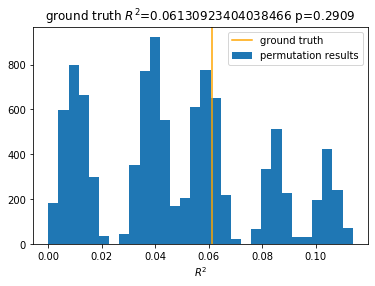

(0.06130923404038466, 0.2909)

In [224]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="CON") & (df_best["loc"] == "ECOG")]["r2"],
                                    df_best[(df_best["lat"]=="CON") & (df_best["loc"] == "STN")]["r2"], True,
                                    r"$R^2$", 10000)

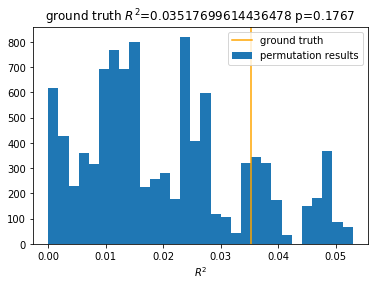

(0.03517699614436478, 0.1767)

In [225]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "ECOG")]["r2"],
                                    df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "STN")]["r2"], True,
                                    r"$R^2$", 10000)

In [226]:
s_ECOG_CON = str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "STN")]["r2"].std(),2)) 


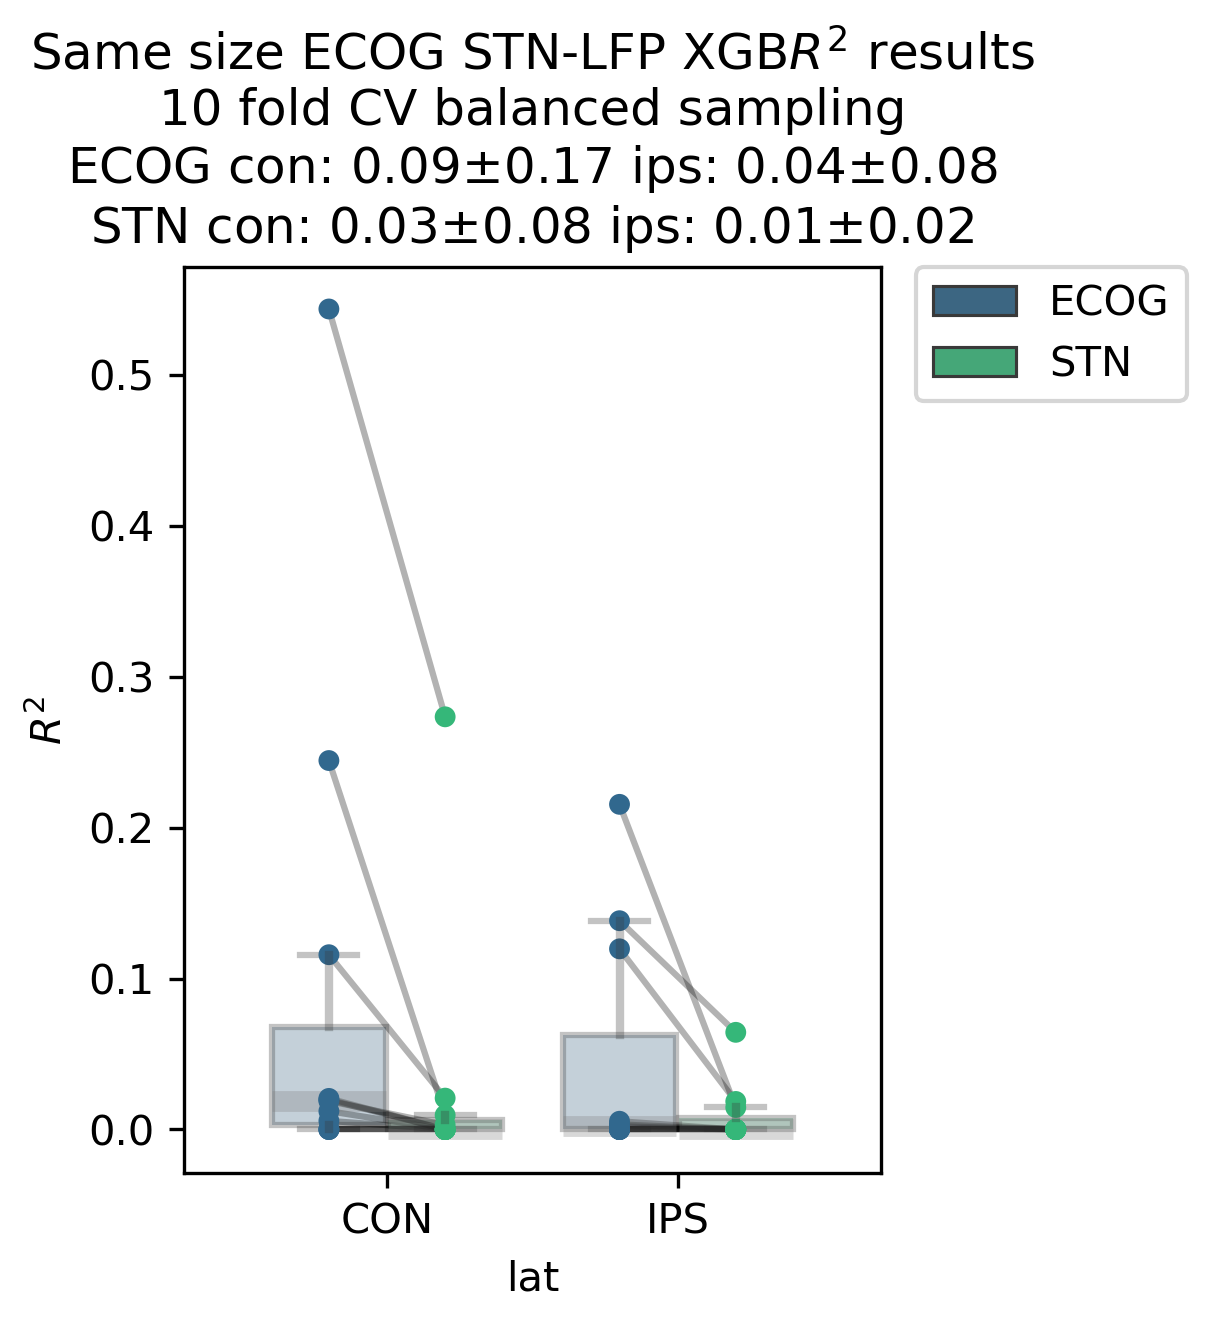

In [227]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["CON", "IPS"], hue_order=["ECOG", "STN"], data=df_best,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False, dodge=True,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["CON", "IPS"], hue_order=["ECOG", "STN"],
             data=df_best, palette="viridis", dodge=True, s=5, jitter=0)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Same size ECOG STN-LFP XGB"+r"$R^2$"+" results\n"+
          "10 fold CV balanced sampling"
          "\nECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)
plt.plot([-0.2,0.2],np.array([df_best[(df_best["loc"]=="ECOG") & (df_best["lat"]=="CON")]["r2"], 
                              df_best[(df_best["loc"]=="STN") & (df_best["lat"]=="CON")]["r2"]]), color='black', alpha=0.3)
plt.plot([0.8,1.2],np.array([df_best[(df_best["loc"]=="ECOG") & (df_best["lat"]=="IPS")]["r2"], 
                              df_best[(df_best["loc"]=="STN") & (df_best["lat"]=="IPS")]["r2"]]), color='black', alpha=0.3)
plt.ylabel(r"$R^2$")
plt.show()

In [228]:
### UPDRS correlation 
df_all = pd.read_csv("..\\Results_Analysis\\df_all.csv", index_col=0)
df_best["UPDRS_total"] = 0
for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
    updrs = list(df_all[(df_all["sub"] == int(sub))]["UPDRS_total"])[0]
    df_best.loc[df_best["sub"] ==sub, 'UPDRS_total'] = np.repeat(updrs, df_best[df_best["sub"] == sub]["UPDRS_total"].shape[0])
    

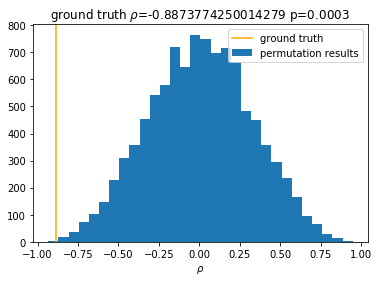

In [229]:
rho_ECOG, p_val_ECOG = icn_permutation_test.permutationTestSpearmansRho(
    [df_best[(df_best["loc"]=="ECOG") & (df_best["sub"] == sub)]["r2"].mean() \
        for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']], 
    [df_best[(df_best["loc"]=="ECOG") & (df_best["sub"] == sub)]["UPDRS_total"].mean() \
        for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']],
                                    True,r"$\rho$", 10000)

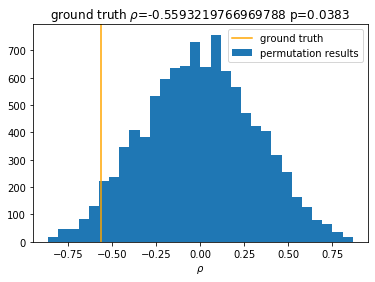

In [230]:
rho_STN, p_val_STN = icn_permutation_test.permutationTestSpearmansRho(
    [df_best[(df_best["loc"]=="STN") & (df_best["sub"] == sub)]["r2"].mean() \
        for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']], 
    [df_best[(df_best["loc"]=="STN") & (df_best["sub"] == sub)]["UPDRS_total"].mean() \
        for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']],
                                    True,r"$\rho$", 10000)

C:\Users\ICN_admin\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


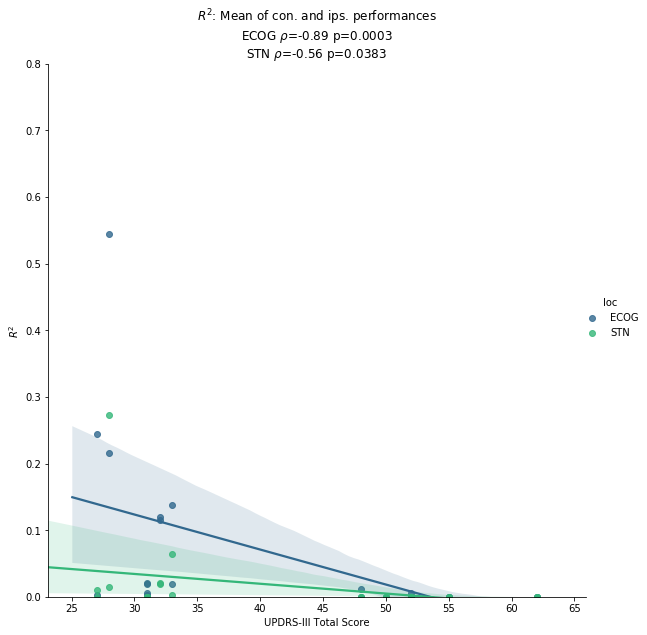

In [231]:
#fig, ax_ = plt.subplots(figsize=(6,4), dpi=200)
#fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sb.lmplot(x="UPDRS_total", y="r2", hue="loc", data=df_best, hue_order=["ECOG", "STN"], 
            palette="viridis", size=10, height=10, legend=True)
plt.ylabel(r"$R^2$")
plt.title(r"$R^2$"+": Mean of con. and ips. performances"+
         #"\nECOG+STN "+ r"$\rho$"+"="+str(np.round(rho_ECOGSTN,2))+" p="+str(p_val_ECOGSTN)+
         "\nECOG "+ r"$\rho$"+"="+str(np.round(rho_ECOG,2))+" p="+str(p_val_ECOG)+
         "\nSTN "+ r"$\rho$"+"="+str(np.round(rho_STN,2))+" p="+str(p_val_STN))
plt.xlabel("UPDRS-III Total Score")
plt.ylim(0, 0.8)
ax.fig.set_figheight(8)
ax.fig.set_figwidth(9)
plt.savefig('Balanced10FoldCV_UPDRS_correlation.jpg', format='png', dpi=300, bbox_inches='tight')

### now get estimations for non same size

In [241]:
df_best = get_df_best_ch_mean_hem(df_non_same_size)

C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


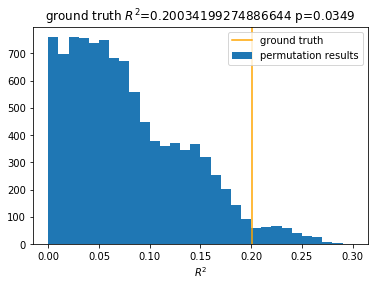

(0.20034199274886644, 0.0349)

In [242]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="CON") & (df_best["loc"] == "ECOG")]["r2"],
                                    df_best[(df_best["lat"]=="CON") & (df_best["loc"] == "STN")]["r2"], True,
                                    r"$R^2$", 10000)

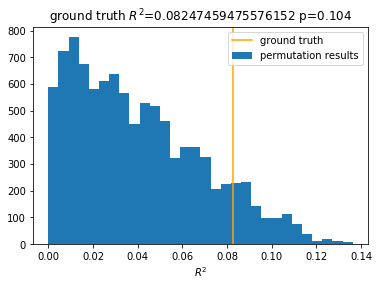

(0.08247459475576152, 0.104)

In [243]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "ECOG")]["r2"],
                                    df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "STN")]["r2"], True,
                                    r"$R^2$", 10000)

In [244]:
s_ECOG_CON = str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df_best[(df_best["lat"] == "IPS") & (df_best["loc"] == "STN")]["r2"].std(),2)) 


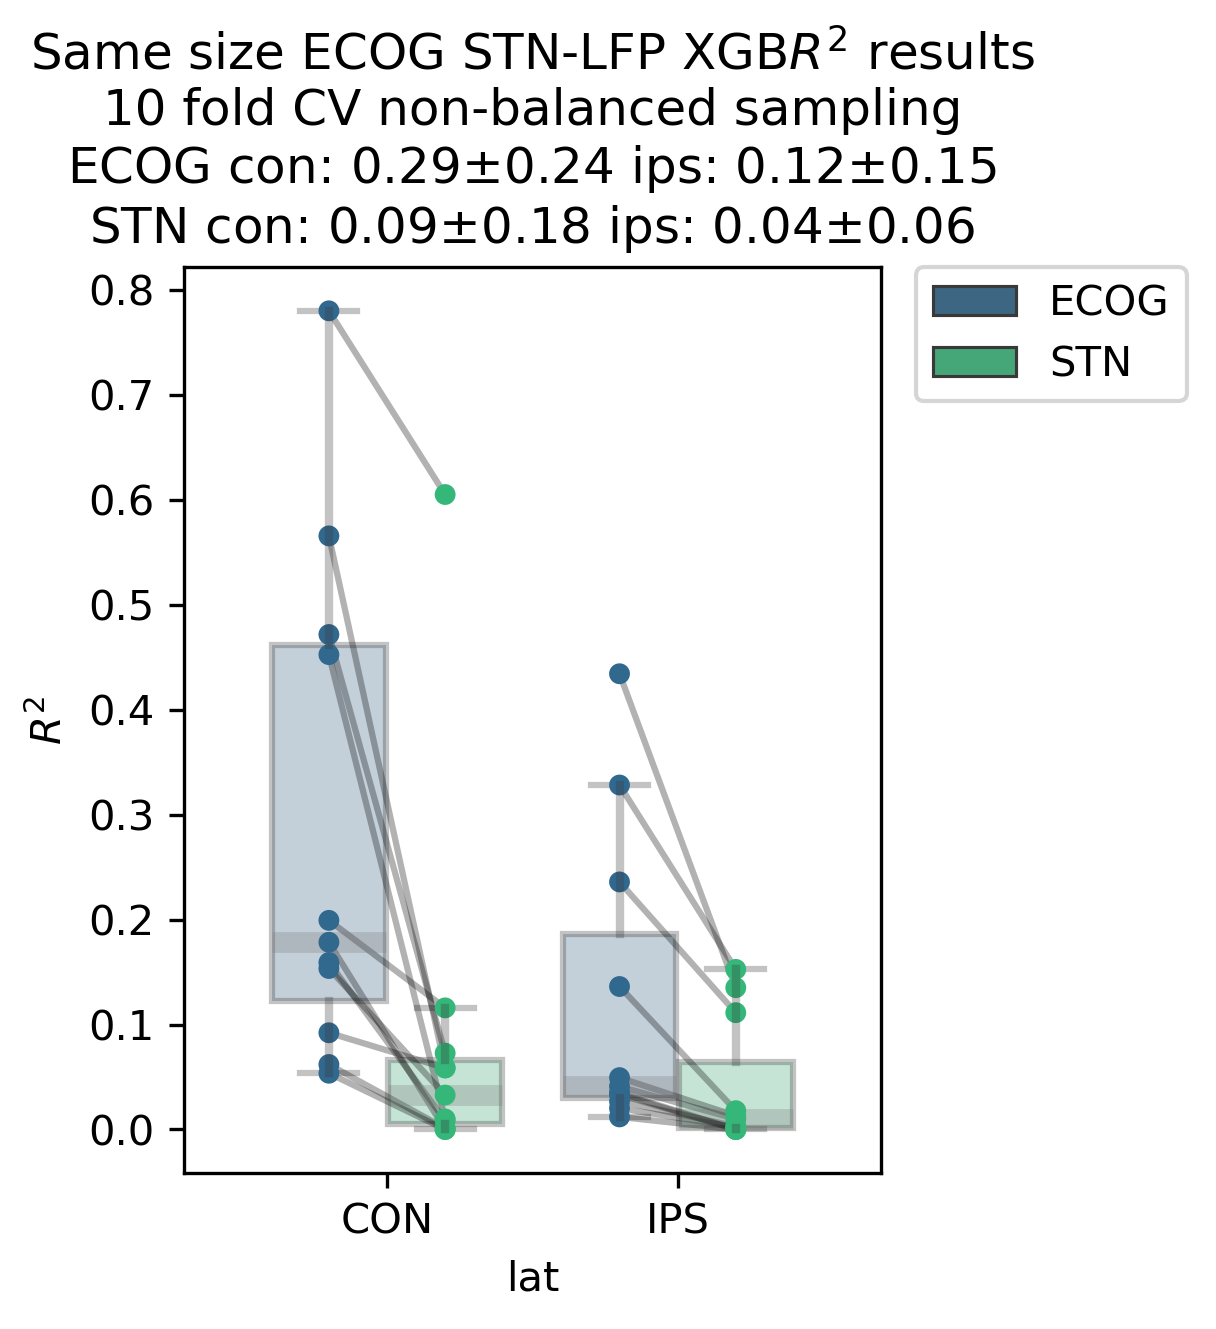

In [245]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["CON", "IPS"], hue_order=["ECOG", "STN"], data=df_best,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False, dodge=True,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["CON", "IPS"], hue_order=["ECOG", "STN"],
             data=df_best, palette="viridis", dodge=True, s=5, jitter=0)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Same size ECOG STN-LFP XGB"+r"$R^2$"+" results\n"+
          "10 fold CV non-balanced sampling"
          "\nECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)
plt.plot([-0.2,0.2],np.array([df_best[(df_best["loc"]=="ECOG") & (df_best["lat"]=="CON")]["r2"], 
                              df_best[(df_best["loc"]=="STN") & (df_best["lat"]=="CON")]["r2"]]), color='black', alpha=0.3)
plt.plot([0.8,1.2],np.array([df_best[(df_best["loc"]=="ECOG") & (df_best["lat"]=="IPS")]["r2"], 
                              df_best[(df_best["loc"]=="STN") & (df_best["lat"]=="IPS")]["r2"]]), color='black', alpha=0.3)
plt.ylabel(r"$R^2$")
plt.show()

In [236]:
### UPDRS correlation 
df_all = pd.read_csv("..\\Results_Analysis\\df_all.csv", index_col=0)
df_best["UPDRS_total"] = 0
for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
    updrs = list(df_all[(df_all["sub"] == int(sub))]["UPDRS_total"])[0]
    df_best.loc[df_best["sub"] ==sub, 'UPDRS_total'] = np.repeat(updrs, df_best[df_best["sub"] == sub]["UPDRS_total"].shape[0])
    

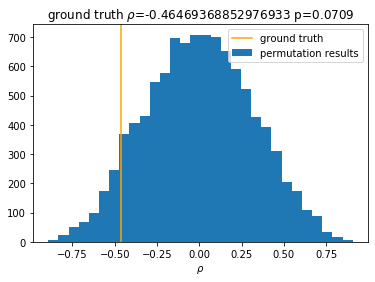

In [237]:
rho_ECOG, p_val_ECOG = icn_permutation_test.permutationTestSpearmansRho(
    [df_best[(df_best["loc"]=="ECOG") & (df_best["sub"] == sub)]["r2"].mean() \
        for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']], 
    [df_best[(df_best["loc"]=="ECOG") & (df_best["sub"] == sub)]["UPDRS_total"].mean() \
        for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']],
                                    True,r"$\rho$", 10000)

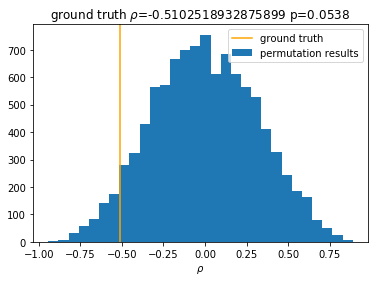

In [238]:
rho_STN, p_val_STN = icn_permutation_test.permutationTestSpearmansRho(
    [df_best[(df_best["loc"]=="STN") & (df_best["sub"] == sub)]["r2"].mean() \
        for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']], 
    [df_best[(df_best["loc"]=="STN") & (df_best["sub"] == sub)]["UPDRS_total"].mean() \
        for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']],
                                    True,r"$\rho$", 10000)

C:\Users\ICN_admin\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


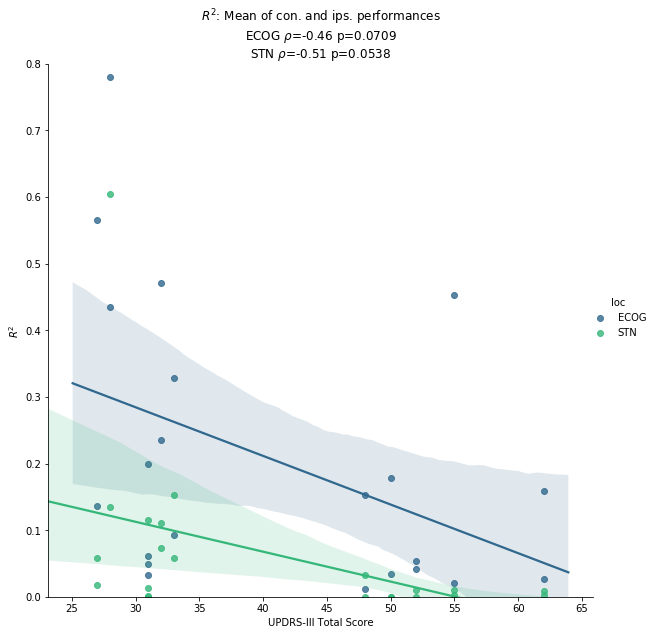

In [239]:
#fig, ax_ = plt.subplots(figsize=(6,4), dpi=200)
#fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sb.lmplot(x="UPDRS_total", y="r2", hue="loc", data=df_best, hue_order=["ECOG", "STN"], 
            palette="viridis", size=10, height=10, legend=True)
plt.ylabel(r"$R^2$")
plt.title(r"$R^2$"+": Mean of con. and ips. performances"+
         #"\nECOG+STN "+ r"$\rho$"+"="+str(np.round(rho_ECOGSTN,2))+" p="+str(p_val_ECOGSTN)+
         "\nECOG "+ r"$\rho$"+"="+str(np.round(rho_ECOG,2))+" p="+str(p_val_ECOG)+
         "\nSTN "+ r"$\rho$"+"="+str(np.round(rho_STN,2))+" p="+str(p_val_STN))
plt.xlabel("UPDRS-III Total Score")
plt.ylim(0, 0.8)
ax.fig.set_figheight(8)
ax.fig.set_figwidth(9)
plt.savefig('NonBalanced10FoldCV_UPDRS_correlation.jpg', format='png', dpi=300, bbox_inches='tight')